In [6]:
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils import data
from PIL import Image
import random
import cv2
import json
import datetime
import multiprocessing
import queue
import threading

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102


# Minimap generation boilerplate

In [12]:
class ImageDataset(data.Dataset):
    def __init__(self, champion_circle_icon_path, minimap_path, fog_path, misc_path, ally_circle_path, enemy_circle_path, dataset_length, save_mode=False, resize=None, thread_pool_size=1):
        self.champion_circle_icon_path = champion_circle_icon_path
        self.minimap_path = minimap_path
        self.fog_path = fog_path
        self.misc_path = misc_path
        self.ally_circle_path = ally_circle_path
        self.enemy_circle_path = enemy_circle_path
        self.dataset_length = dataset_length
        self.save_mode = save_mode
        self.resize = resize
        self.thread_pool_size = thread_pool_size
        
        self.champion_icons = []
        self.minimaps = []
        self.fogs = []
        self.miscs = []
        self.ally_circle = None
        self.enemy_circle = None
        
        def load_results(path, array):
            for p in os.listdir(path):
                p = os.path.join(path, p)
                result = self.load_image(p)
                if result:
                    img, label = result
                    array.append((img, label))
    
        load_results(self.champion_circle_icon_path, self.champion_icons)
        load_results(self.minimap_path, self.minimaps)
        load_results(self.fog_path, self.fogs)
        load_results(self.misc_path, self.miscs)
        self.champion_icons.sort(key = lambda x: x[1])  
        
        self.minimap_size = tuple(self.minimaps[0][0].shape[1:3])
        self.minimap_ratio = (self.resize[1] / self.minimap_size[0], self.resize[0] / self.minimap_size[1])
        self.minimap_size = (int(self.minimap_size[0] * self.minimap_ratio[0]), int(self.minimap_size[1] * self.minimap_ratio[1]))
        
        self.id_to_champion = {}
        self.champion_to_id = {}
        int_champion = 1
        for c, label in self.champion_icons:
            b = c.numpy()
            b = b.transpose((2, 1, 0))
            h, w = b.shape[:2]
            b[b[..., 3] == 0] = (0.0, 0.0, 0.0, 0.0)
            b = b.transpose((2, 1, 0))
            c = torch.from_numpy(b)
            
            self.id_to_champion[int_champion] = label
            self.champion_to_id[label] = int_champion
            
            int_champion += 1

        for c, _ in self.miscs:
            b = c.numpy()
            b = b.transpose((2, 1, 0))
            h, w = b.shape[:2]
            b[b[..., 3] == 0] = (0.0, 0.0, 0.0, 0.0)
            b = b.transpose((2, 1, 0))
            c = torch.from_numpy(b)
        
        self.red_outer_towers = []
        self.red_normal_tower = None
        self.red_inhib = None
        self.red_nexus = None

        self.blue_outer_towers = []
        self.blue_normal_tower = None
        self.blue_inhib = None
        self.blue_nexus = None
        
        for m, label in self.miscs:
            if 'tower' in label or 'inhib' in label or 'nexus' in label:
                m = m.numpy()
                m = m.transpose((2, 1, 0))
                #m[m[..., 0] > 0.2] = (28/255, 79/255, 93/255, 1.0)
                lighter = m[..., 0] > 0.5
                darker = m[..., 0] > 0.2
                
                blue = m.copy()
                blue[darker] = (28/255, 79/255, 93/255, 1.0)
                blue[lighter] = (60/255, 167/255, 199/255, 1.0)

                red = m.copy()
                red[darker] = (92/255, 24/255, 25/255, 1.0)
                red[lighter] = (189/255, 52/255, 51/255, 1.0)
                
                red = red.transpose((2, 1, 0))
                blue = blue.transpose((2, 1, 0))
                
                m = m.transpose((2, 1, 0))
                
                if 'tower_minimap' in label:
                    red = torch.from_numpy(red)
                    blue = torch.from_numpy(blue)
                    self.red_outer_towers.append((red, label + '_red'))
                    self.blue_outer_towers.append((blue, label + '_blue'))
                    red = red.numpy()
                    blue = blue.numpy() 
                if 'icon_ui_tower_minimap' == label: # regular tower
                    red = torch.from_numpy(red)
                    blue = torch.from_numpy(blue)
                    self.red_normal_tower = (red, label + '_red')
                    self.blue_normal_tower = (blue, label + '_blue')
                elif 'inhib' in label:
                    #red = cv2.resize(red, (0, 0), fx = 2.0, fy = 2.0, interpolation = cv2.INTER_AREA)
                    #blue = cv2.resize(blue, (0, 0), fx = 2.0, fy = 2.0, interpolation = cv2.INTER_AREA)
                    red = torch.from_numpy(red)
                    blue = torch.from_numpy(blue)
                    self.red_inhib = (red, label + '_red')
                    self.blue_inhib = (blue, label + '_blue')
                elif 'nexus' in label:
                    red = red.transpose((2, 1, 0))
                    blue = blue.transpose((2, 1, 0))
                    scale = 1.5
                    red = cv2.resize(red, (0, 0), fx = scale, fy = scale, interpolation = cv2.INTER_AREA)
                    blue = cv2.resize(blue, (0, 0), fx = scale, fy = scale, interpolation = cv2.INTER_AREA)
                    red = red.transpose((2, 1, 0))
                    blue = blue.transpose((2, 1, 0))
                    red = torch.from_numpy(red)
                    blue = torch.from_numpy(blue)
                    self.red_nexus = (red, label + '_red')
                    self.blue_nexus = (blue, label + '_blue')
        
        def MakePos(x, y):
            m_x = 14640.673
            m_y = 14777.2646
            offset_x = 200#-2000
            offset_y = -800
            result_x = (x - offset_x) / m_x
            result_y = (m_y - (y - offset_y)) / m_y
            return result_x, result_y        
        
        self.blue_tower_pos_bot_a = MakePos(10097.62, 808.73)
        self.blue_tower_pos_bot_b = MakePos(6512.53, 1262.62)
        self.blue_tower_pos_bot_c = MakePos(3747.26, 1041.04)        
        
        self.blue_tower_pos_mid_a = MakePos(5448.02, 6169.10)
        self.blue_tower_pos_mid_b = MakePos(4657.66, 4591.91)
        self.blue_tower_pos_mid_c = MakePos(3233.99, 3447.24)

        self.blue_tower_pos_top_a = MakePos(574.66, 10220.47)
        self.blue_tower_pos_top_b = MakePos(1106.26, 6485.25)
        self.blue_tower_pos_top_c = MakePos(802.81, 4052.36)

        self.red_tower_pos_bot_a = MakePos(13459.0, 4284.0)
        self.red_tower_pos_bot_b = MakePos(12920.0, 8005.0)
        self.red_tower_pos_bot_c = MakePos(13205.0, 10474.0)
        
        self.red_tower_pos_mid_a = MakePos(8548.0, 8289.0)
        self.red_tower_pos_mid_b = MakePos(9361.0, 9892.0)
        self.red_tower_pos_mid_c = MakePos(10743.0, 11010.0)
        
        self.red_tower_pos_top_a = MakePos(3911.0, 13654.0)
        self.red_tower_pos_top_b = MakePos(7536.0, 13190.0)
        self.red_tower_pos_top_c = MakePos(10261.0, 13465.0)
        
        self.blue_tower_pos_nexus_top = MakePos(1271.097, 1989.8077)
        self.blue_tower_pos_nexus_bot = MakePos(1821.097, 1589.8077)
        
        self.red_tower_pos_nexus_top = MakePos(12621.097, 12364.8077)
        self.red_tower_pos_nexus_bot = MakePos(12171.097, 12789.8077)
        
        self.blue_inhib_pos_top = MakePos(796.097, 3339.8077)
        self.blue_inhib_pos_mid = MakePos(2746.097, 2964.8077)
        self.blue_inhib_pos_bot = MakePos(2996.097, 1014.8077)
        
        self.red_inhib_pos_top = MakePos(10946.097, 13414.8077)
        self.red_inhib_pos_mid = MakePos(11196.097, 11439.8077)
        self.red_inhib_pos_bot = MakePos(13196.097, 11164.8077)
        
        self.blue_nexus_pos = MakePos(1146.097, 1414.8077)
        self.red_nexus_pos = MakePos(12771.097, 13014.8077)
        
        ### other
        self.blue_gromp_pos = MakePos(1950, 7960)
        self.blue_wolves_pos = MakePos(3600, 6000)
        self.blue_raptors_pos = MakePos(6800, 4900)
        self.blue_krugs_pos = MakePos(8100, 2100)
        
        self.red_gromp_pos = MakePos(12300, 6000)
        self.red_wolves_pos = MakePos(10800, 7900)
        self.red_raptors_pos = MakePos(7600, 9100)
        self.red_krugs_pos = MakePos(6200, 11800)

        self.small_camps = [(None, 'None')]
        for m, label in self.miscs:
            if 'lesser_jungle_icon_v2' == label or 'camp_respawn_urgent' == label:
                self.small_camps.append((m, label))
            
        self.blue_blue_buff_pos = MakePos(3500, 7600)
        self.blue_red_buff_pos = MakePos(7500, 3500)
        
        self.red_blue_buff_pos = MakePos(10800, 6500)
        self.red_red_buff_pos = MakePos(6800, 10500)

        self.buff_camps = [(None, 'None')]
        for m, label in self.miscs:
            if 'camp' == label or 'camp_respawn' == label or 'camp_respawn_urgent' == label:
                self.buff_camps.append((m, label))
        
        self.top_scuttle = MakePos(4200, 9200)
        self.bot_scuttle = MakePos(10200, 4700)
        
        self.scuttle = [(None, 'None')]
        for m, label in self.miscs:
            if 'lesser_jungle_icon_v2' == label or 'camp_respawn' == label or 'camp_respawn_urgent' == label or 'minimap_ward_green' == label or 'minimap_ward_green_enemy' == label:
                self.scuttle.append((m, label))
        
        self.blue_gromp_plant_pos = MakePos(2900, 9200)
        self.blue_gromp_plant_vision_pos = MakePos(3300, 8200)
        self.blue_gromp_plant_heal_pos = MakePos(3500, 9250)
        self.blue_gromp_plant_heal2_pos = MakePos(4200, 8700)
        self.blue_blue_buff_plant_pos = MakePos(4400, 6600)
        
        self.blue_red_buff_base_plant_pos = MakePos(6000, 2800)
        self.blue_red_buff_plant_pos = MakePos(8800, 3100)
        self.blue_red_buff_plant_vision_pos = MakePos(8700, 4000)

        self.red_gromp_plant_pos = MakePos(11700, 4400)
        self.red_gromp_plant_vision_pos = MakePos(11200, 5400)
        self.red_gromp_plant_heal_pos = MakePos(11400, 4200)
        self.red_blue_buff_plant_pos = MakePos(10200, 7000)
        
        self.red_red_buff_base_plant_pos = MakePos(8600, 10700)
        self.red_red_buff_plant_pos = MakePos(5950, 10400)
        self.red_red_buff_plant_vision_pos = MakePos(5930, 9300)        

        self.plants = [(None, 'None')]
        for m, label in self.miscs:
            if 'plant_icon_green' == label:
                self.plants.append((m, label))            
        
        self.baron_pos = MakePos(4700, 9900)        
        self.dragon_pos = MakePos(9700, 4000)        

        self.baron = [(None, 'None')]
        for m, label in self.miscs:
            if 'sru_riftherald_minimap_icon' == label or 'baron_minimap_icon' == label:
                self.baron.append((m, label))
                
        self.dragon = [(None, 'None')]
        for m, label in self.miscs:
            if 'dragonairminimap' == label or 'dragonearthminimap' == label or 'dragonfireminimap' == label or 'dragonwaterminimap' == label or 'dragonelderminimap' == label:
                self.dragon.append((m, label))       
        
        self.buff_camps = [(None, 'None')]
        self.ally_champion_outlines = []
        self.enemy_champion_outlines = []
        for m, label in self.miscs:
            m = m.numpy()
            m = m.transpose((2, 1, 0))
            #m = cv2.resize(m, (0, 0), fx = 2.0, fy = 2.0, interpolation = cv2.INTER_AREA)
            m = cv2.resize(m, (120, 120), interpolation = cv2.INTER_AREA)
            m = m.transpose((2, 1, 0))
            m = torch.from_numpy(m)

            if 'ally_circle' == label or 'recalloutline' == label or 'teleporthighlight_friendly' == label or 'teleporthighlight_shen' == label:
                self.ally_champion_outlines.append((m, label))
            if 'enemy_circle' == label or 'recallhostileoutline' == label or 'teleporthighlight_enemy' == label or 'teleporthighlight_shen' == label:
                self.enemy_champion_outlines.append((m, label))
        
        self.blue_minion = None
        self.red_minion = None
        self.pings = []
        self.wards = []
        self.shop = None
        self.blue_shop_pos = MakePos(0, 800)
        self.red_shop_pos = MakePos(14200, 14200)
        for m, label in self.miscs:
            '''
            m = m.numpy()
            m = m.transpose((2, 1, 0))
            #m = cv2.resize(m, (0, 0), fx = 2.0, fy = 2.0, interpolation = cv2.INTER_AREA)
            m = cv2.resize(m, (120, 120), interpolation = cv2.INTER_AREA)
            m = m.transpose((2, 1, 0))
            m= torch.from_numpy(m)
            '''
            if 'minionmapcircle_ally' == label:
                self.blue_minion = (m, label)
            elif 'minionmapcircle_enemy' == label:
                self.red_minion = (m, label)
            elif 'pingcomehere' == label or 'pinggetback' == label or 'pingmia' == label or 'pingomw' == label:
                m = m.numpy()
                m = m.transpose((2, 1, 0))
                m = cv2.resize(m, (32, 32), interpolation = cv2.INTER_AREA)
                m = m.transpose((2, 1, 0))
                m= torch.from_numpy(m)
                self.pings.append((m, label))
            elif 'pingmarker' == label or 'pingmarker_green' == label or 'pingmarker_red' == label:
                self.pings.append((m, label))
            elif 'minimap_jammer' in label or 'minimap_ward' in label:
                self.wards.append((m, label))
            elif 'shop' == label:
                self.shop = (m, label)
        
        self.datas = queue.Queue(self.dataset_length)
        if not self.save_mode:
            if self.thread_pool_size == 1:
                for i in range(dataset_length):
                    data = self.generate_data(i)
                    self.datas.put(data)
            else:
                self.threads = []
                for i in range(self.thread_pool_size):
                    t = threading.Thread(target=self.thread_generate_data)
                    t.start()
                    self.threads.append(t)
            
    def __getitem__(self, index):
        data = self.datas.get()
        self.datas.task_done()
        return data
    
    def thread_generate_data(self):
        while True:
            data = self.generate_data(0)
            self.datas.put(data)
    
    def load_image(self, p):
        if os.path.isfile(p):
            full_p = os.path.basename(p)
            split = os.path.splitext(full_p)
            basefile = split[0]
            extension = split[1]
            if extension == '.png':
                img = Image.open(p).convert("RGBA")
                img = transforms.ToTensor()(img)
                return (img, basefile)
        return None

    def sample_list(self, l, amount):
        vals = np.random.choice(len(l), size=amount, replace=False)
        samples = [l[i] for i in vals]
        return samples
    
    def overlay_transparent(self, background, overlay, x, y, overlay_size=None):
        """
        @brief      Overlays a transparant PNG onto another image using CV2

        @param      background_img    The background image
        @param      img_to_overlay_t  The transparent image to overlay (has alpha channel)
        @param      x                 x location to place the top-left corner of our overlay
        @param      y                 y location to place the top-left corner of our overlay
        @param      overlay_size      The size to scale our overlay to (tuple), no scaling if None

        @return     Background image with overlay on top
        """

        background_width = background.shape[1]
        background_height = background.shape[0]

        if x >= background_width or y >= background_height:
            return background

        h, w = overlay.shape[0], overlay.shape[1]
        if h == 0 or w == 0:
            return

        if x + w > background_width:
            w = background_width - x
            overlay = overlay[:, :w]

        if y + h > background_height:
            h = background_height - y
            overlay = overlay[:h]

        if overlay.shape[2] < 4:
            overlay = np.concatenate(
                [
                    overlay,
                    np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype)
                ],
                axis = 2,
            )

        overlay_image = overlay[..., :4]
        mask = overlay[..., 3:]

        #print(background.shape, overlay.shape, overlay_image.shape, y, y+h, x, x+h)
        x = max(x, 0)
        y = max(y, 0)
        background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

        return background

    def overlay(self, champion, circle, y = 0, x = 0):
        kernel = np.ones((3,3), np.uint8)
        circle = circle.transpose((2, 1, 0))
        
        #circle = cv2.GaussianBlur(circle, (1, 1), 0)
        #circle = cv2.morphologyEx(circle, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        #circle = cv2.dilate(circle, kernel, iterations = 1)
        #circle = cv2.cvtColor(circle, cv2.COLOR_RGBA2RGB)
        #circle_rgb = cv2.cvtColor(circle, cv2.COLOR_RGBA2RGB)
        
        champion = champion.transpose((2, 1, 0))
        #champion_rgb = cv2.cvtColor(champion, cv2.COLOR_RGBA2RGB)
        
        b = self.overlay_transparent(champion, circle, x, y)

        b = b.transpose((2, 1, 0))
        return b        
    
    # obtain the sample with the given index
    def generate_data(self, index):
        minimap = random.choice(self.minimaps)
        fog = random.choice(self.fogs)

        champion_icons = self.sample_list(self.champion_icons, 10)
        ally_champion_icons = champion_icons[:5]
        enemy_champion_icons = champion_icons[5:]
        
        ally_champions = []
        for c, label in ally_champion_icons:
            c = c.numpy().copy()
            consider_other_than_outline = 0
            while consider_other_than_outline != 10:
                circle, c_label = self.sample_list(self.ally_champion_outlines, 1)[0]
                if 'circle' in c_label:
                    break
                else:
                    consider_other_than_outline += 1
            circle = circle.numpy()
            c = self.overlay(c, circle)
            ally_champions.append((c, label))

        enemy_champions = []
        for c, label in enemy_champion_icons:
            c = c.numpy().copy()
            consider_other_than_outline = 0
            while consider_other_than_outline != 10:
                circle, c_label = self.sample_list(self.enemy_champion_outlines, 1)[0]
                if 'circle' in c_label:
                    break
                else:
                    consider_other_than_outline += 1            
            circle = circle.numpy()
            c = self.overlay(c, circle)
            enemy_champions.append((c, label))

        minimap, _ = minimap
        minimap = minimap.numpy().copy()
        fog, _ = fog
        fog = fog.numpy()
        alpha = 0.9
        b = cv2.addWeighted(minimap, alpha, fog, 1 - alpha, 0)

        overlay_operations = []
        fog_filter_operations = []
        
        def DrawOperation(img, x, y):
            overlay_operations.append((img, x, y))
        def FogFilterOperation(img, y, x):
            fog_filter_operations.append((img, x, y))
        
        h, w = minimap.shape[1:3]

        # towers
        def load_tower2(minimap, img, pos, randomness):
            if random.random() < randomness:
                return minimap
            
            img = img.numpy()
            x, y = pos
            h, w = minimap.shape[1:3]
            x = int(x * w)
            y = int(y * h)
            
            DrawOperation(img, x, y)
            FogFilterOperation(img, x, y)
            #b = self.overlay(minimap, img, x, y)
            return b

        def load_tower(minimap, l, pos, randomness=0.1):
            if isinstance(l, list):
                tower, _ = random.choice(l)
            else:
                tower, _ = l
                
            b = load_tower2(minimap, tower, pos, randomness)
            return b

        b = load_tower(b, self.red_outer_towers, self.red_tower_pos_top_a)
        b = load_tower(b, self.red_outer_towers, self.red_tower_pos_mid_a)
        b = load_tower(b, self.red_outer_towers, self.red_tower_pos_bot_a)

        b = load_tower(b, self.blue_outer_towers, self.blue_tower_pos_top_a)
        b = load_tower(b, self.blue_outer_towers, self.blue_tower_pos_mid_a)
        b = load_tower(b, self.blue_outer_towers, self.blue_tower_pos_bot_a)

        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_top_b)
        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_mid_b)
        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_bot_b)

        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_top_b)
        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_mid_b)
        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_bot_b)

        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_top_c)
        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_mid_c)
        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_bot_c)

        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_top_c)
        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_mid_c)
        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_bot_c)

        b = load_tower(b, self.blue_inhib, self.blue_inhib_pos_top)
        b = load_tower(b, self.blue_inhib, self.blue_inhib_pos_mid)
        b = load_tower(b, self.blue_inhib, self.blue_inhib_pos_bot)

        b = load_tower(b, self.red_inhib, self.red_inhib_pos_top)
        b = load_tower(b, self.red_inhib, self.red_inhib_pos_mid)
        b = load_tower(b, self.red_inhib, self.red_inhib_pos_bot)

        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_nexus_top)
        b = load_tower(b, self.blue_normal_tower, self.blue_tower_pos_nexus_bot)

        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_nexus_top)
        b = load_tower(b, self.red_normal_tower, self.red_tower_pos_nexus_bot)

        b = load_tower(b, self.blue_nexus, self.blue_nexus_pos)
        b = load_tower(b, self.red_nexus, self.red_nexus_pos)      

        b = load_tower(b, self.shop, self.blue_shop_pos, 0.0)
        b = load_tower(b, self.shop, self.red_shop_pos, 0.0)
        
        def load_maybe_spawn(minimap, l, pos):
            img, _ = random.choice(l)
            if img == None:
                return minimap
            img = img.numpy()
            x, y = pos
            h, w = minimap.shape[1:3]
            x = int(x * w)
            y = int(y * h)
            
            DrawOperation(img, x, y)
            #b = self.overlay(minimap, img, x, y)
            return b
                
        b = load_maybe_spawn(b, self.small_camps, self.blue_gromp_pos)
        b = load_maybe_spawn(b, self.small_camps, self.blue_wolves_pos)
        b = load_maybe_spawn(b, self.small_camps, self.blue_raptors_pos)
        b = load_maybe_spawn(b, self.small_camps, self.blue_krugs_pos)
        b = load_maybe_spawn(b, self.small_camps, self.red_gromp_pos)
        b = load_maybe_spawn(b, self.small_camps, self.red_wolves_pos)
        b = load_maybe_spawn(b, self.small_camps, self.red_raptors_pos)
        b = load_maybe_spawn(b, self.small_camps, self.red_krugs_pos)

        b = load_maybe_spawn(b, self.buff_camps, self.blue_blue_buff_pos)
        b = load_maybe_spawn(b, self.buff_camps, self.blue_red_buff_pos)
        b = load_maybe_spawn(b, self.buff_camps, self.red_blue_buff_pos)
        b = load_maybe_spawn(b, self.buff_camps, self.red_red_buff_pos)
        
        b = load_maybe_spawn(b, self.scuttle, self.top_scuttle)
        b = load_maybe_spawn(b, self.scuttle, self.bot_scuttle)        
        
        b = load_maybe_spawn(b, self.plants, self.blue_gromp_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_gromp_plant_vision_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_gromp_plant_heal_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_gromp_plant_heal2_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_blue_buff_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_red_buff_base_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_red_buff_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.blue_red_buff_plant_vision_pos)
        b = load_maybe_spawn(b, self.plants, self.red_gromp_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.red_gromp_plant_vision_pos)
        b = load_maybe_spawn(b, self.plants, self.red_gromp_plant_heal_pos)
        b = load_maybe_spawn(b, self.plants, self.red_blue_buff_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.red_red_buff_base_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.red_red_buff_plant_pos)
        b = load_maybe_spawn(b, self.plants, self.red_red_buff_plant_vision_pos)
        
        b = load_maybe_spawn(b, self.baron, self.baron_pos)
        b = load_maybe_spawn(b, self.dragon, self.dragon_pos)

        ### minions
        w, h = minimap.shape[1:3]
        
        b_minion, label = self.blue_minion
        r_minion, label = self.red_minion
        b_minion = b_minion.numpy()
        r_minion = r_minion.numpy()
        
        def spawn_minion_side(x, h, minion):
            noise = 50
            diff = 100
            is_line = random.random()
            if is_line < 0.5:
                y = random.randint(diff, h)
                blue_or_red_side = random.random()
                if blue_or_red_side < 0.5:
                    x, y = y, x
                for i in range(6):
                    if blue_or_red_side < 0.5:
                        x += 10
                    else:
                        y += 10
                    DrawOperation(minion, x, y)
                    FogFilterOperation(minion, x, y)
            else:
                #grouped
                y = random.randint(diff, h)
                blue_or_red_side = random.random()
                if blue_or_red_side < 0.5:
                    x, y = y, x
                for i in range(6):
                    x_diff = random.randint(-15, 15)
                    y_diff = random.randint(-15, 15)
                    x_new = x + x_diff
                    y_new = y + y_diff
                    DrawOperation(minion, x_new, y_new)
                    FogFilterOperation(minion, x_new, y_new)
        
        def spawn_minion_middle(h, w, minion):
            diff = 100
            x = random.randint(diff, h - diff)
            y = h - x
            
            is_line = random.random()
            if is_line < 0.5:
                for i in range(6):
                    x += 13
                    y -= 13
                    DrawOperation(minion, x, y)
                    FogFilterOperation(minion, x, y)
            else:
                #grouped
                blue_or_red_side = random.random()
                for i in range(6):
                    x_diff = random.randint(-15, 15)
                    y_diff = random.randint(-15, 15)
                    x_new = x + x_diff
                    y_new = y + y_diff
                    DrawOperation(minion, x_new, y_new)
                    FogFilterOperation(minion, x_new, y_new)        
        
        spawn_minion_side(45, h, b_minion)
        spawn_minion_side(45, h, r_minion)
        spawn_minion_side(w - 45, h, b_minion)
        spawn_minion_side(w - 45, h, r_minion)
        
        spawn_minion_middle(w, h, b_minion)
        spawn_minion_middle(w, h, r_minion)
        
        ### wards
        w, h = minimap.shape[1:3]
        num_wards = random.randint(0, 10)
        for i in range(num_wards):
            ward, label = self.sample_list(self.wards, 1)[0]
            ward = ward.numpy()
            constraint_distance = 50
            x = random.randint(constraint_distance, w - constraint_distance)
            y = random.randint(constraint_distance, h - constraint_distance)
            DrawOperation(ward, x, y)
            FogFilterOperation(ward, x, y)
                
        ### champion data
        champion_data = []
        
        def AddChampions(minimap, champions, b):
            w, h = minimap.shape[1:3]
            for c, label in champions:
                c_w, c_h = c.shape[1:3]

                c = c.transpose((2, 1, 0))
                c = cv2.resize(c, (0, 0), fx = 0.5, fy = 0.5, interpolation = cv2.INTER_AREA)
                c = c.transpose((2, 1, 0))
                c_w, c_h = c.shape[1:3]
                c_w = int(c_w / 2.0)
                c_h = int(c_h / 2.0)
                x = random.randint(-c_w + 1, w - c_w)
                y = random.randint(-c_h + 1, h - c_h)
                
                if len(champion_data) > 0:
                    if random.random() < 0.2:
                        other_champion = random.choice(champion_data)
                        other_c, other_x, other_y, other_c_w, _ = other_champion
                        #print(other_c, other_x, other_y)
                        nearness = c_w
                        bias_x = pow(random.random(), 0.5) * (-1 if random.random() < 0.5 else 1)
                        bias_y = pow(random.random(), 0.5) * (-1 if random.random() < 0.5 else 1)
                        x = int(other_x + nearness * bias_x)
                        y = int(other_y + nearness * bias_y)
                        #print(other_c, other_x, other_y, label, x, y)
                        x = max(-c_w + 1, min(x, w - c_w))
                        y = max(-c_h + 1, min(y, h - c_h))

                orig_x = x
                orig_y = y
                
                if x >= w - c_w * 2.0:
                    c = c[:,:,:int(w-x)]
                if x < 0:
                    c = c[:,:,-int(c_w * 2 + x):]
                    x = 0
                if y >= h - c_h * 2.0:
                    c = c[:,:int(h-y),:]
                if y < 0:
                    c = c[:,-int(c_h * 2 + y):,:]
                    y = 0

                c_w, c_h = c.shape[1:3]
                                
                state = (label, int(y * self.minimap_ratio[1]), int(self.minimap_ratio[0] * x), int(self.minimap_ratio[1] * c_w), int(self.minimap_ratio[0] * c_h))
                
                #c_w2 = c_w * ratio_w
                #c_h2 = c_h * ratio_h
                #print(ratio_h, ratio_w, c_h2, c_w2)
                #state = (label, (y + (c_h/2)) * ratio_h, (x + (c_w/2)) * ratio_w, c_h2, c_w2)
                                
                DrawOperation(c, x, y)
                FogFilterOperation(c, x, y)
                                
                champion_data.append(state)
            return b

        b = AddChampions(minimap, ally_champions, b)
        b = AddChampions(minimap, enemy_champions, b)
                
        ### pings
        w, h = minimap.shape[1:3]
        num_pings = random.randint(3, 10)
        for i in range(num_pings):
            ping, label = self.sample_list(self.pings, 1)[0]
            ping = ping.numpy()
            constraint_distance = 0 # distance away from center            
            x = random.randint(constraint_distance, w - constraint_distance)
            y = random.randint(constraint_distance, h - constraint_distance)
            
            if random.random() < 1:
                other_champion = random.choice(champion_data)
                other_c, other_x, other_y, other_c_w, other_c_h = other_champion
                other_x *= 1 / self.minimap_ratio[0]
                other_y *= 1 / self.minimap_ratio[1]
                nearness = other_c_w
                #bias_x = pow(random.random(), 0.5) * (-1 if random.random() < 0.5 else 1)
                #bias_y = pow(random.random(), 0.5) * (-1 if random.random() < 0.5 else 1)
                #x = int(other_x + nearness * bias_x)
                #y = int(other_y + nearness * bias_y)
                #x = max(-constraint_distance + 1, min(x, w - constraint_distance))
                #y = max(-constraint_distance + 1, min(y, h - constraint_distance))
                x = other_y
                y = other_x
                bias_x = random.random() * (-1 if random.random() < 0.5 else 1)
                bias_y = random.random() * (-1 if random.random() < 0.5 else 1)
                x = int(x + nearness * bias_x)
                y = int(y + nearness * bias_y)
                
            x = int(x)
            y = int(y)
            
            # create circle wave
            ping_h, ping_w = ping.shape[1:3]
            ping = ping.transpose((2, 1, 0))
            
            color = ping[int(ping_h / 2), int(ping_w / 2), :]
            color = [x.item() for x in color]
            
            ww = random.randint(ping_w, ping_w * 5)
            ww_h = int(ww / 2)

            circle_x = x - ww_h + int(ping_w)#int(ping_w / 2)
            circle_y = y - ww_h + int(ping_h)#int(ping_h / 2)
            circle = np.zeros((ww, ww, 4), dtype=np.float32)
            ping_center_x, ping_center_y = ww_h, ww_h
            
            number_times = random.randint(0, 4)
            for i in range(number_times):
                radius = random.randint(1, ww_h)
                thickness = random.randint(1, ww_h)
                color[3] = min(0.6, max(0.1, random.random()))
                if thickness < 20:
                    color[3] *= min(0.8, color[3] * 1.5)
                circle = cv2.circle(circle, (ping_center_x, ping_center_y), radius, color, thickness, lineType=cv2.LINE_AA)

            circle = circle.transpose((2, 1, 0))
            
            ping = ping.transpose((2, 1, 0))
            
            DrawOperation(circle, circle_x, circle_y)
            DrawOperation(ping, x, y)

        ### add fog light
        w, h = minimap.shape[1:3]

        fog_filter = np.zeros(minimap.shape, minimap.dtype)
        fog_filter = fog_filter.transpose((2, 1, 0)).copy()
        
        for img, x, y in fog_filter_operations:
            h, w = img.shape[1:3]
            distance = 40
            
            x = int(x + w / 2)
            y = int(y + h / 2)
            
            fog_filter = cv2.circle(fog_filter, (x, y), distance, (0.0, 0.0, 0.0, 1.0), -1) 
        
        fog_filter_black = fog_filter
        fog_filter = fog_filter.transpose((2, 1, 0))

        fog_mask = fog_filter.astype('uint8')
        fog_mask = fog_mask.transpose((2, 1, 0))
        fog_mask[fog_mask[...] == 1] = 255
        fog_mask = cv2.split(fog_mask)[3]
        
        fog_filter = fog_filter.transpose((2, 1, 0))
        minimap = minimap.transpose((2, 1, 0))

        fog_filter = cv2.bitwise_or(minimap, fog_filter, mask=fog_mask)
        fog_filter[fog_filter[..., 3] == 0] = (0.0, 0.0, 0.0, 1.0)
        
        minimap = minimap.transpose((2, 1, 0))
        fog_filter = fog_filter.transpose((2, 1, 0))
        
        alpha = 0.3
        b = cv2.addWeighted(minimap, alpha, fog_filter, 1 - alpha, 0)
        
        ### overlays
        for img, x, y in overlay_operations:
            b = self.overlay(b, img, x, y)
        
        b = b.transpose((2, 1, 0)).copy()
        
        # draw random line
        label, x, y, c_w, c_h = self.sample_list(champion_data, 1)[0]
        my_champion_point = [int(x + (c_w / 2)), int(y + (c_h / 2))]
        target_random_point = [random.randint(0, w), random.randint(0, h)]
        points = []

        diff_x = (target_random_point[0] - my_champion_point[0])
        diff_y = (target_random_point[1] - my_champion_point[1])
        for i in range(5):
            i /= 5.0
            noise_size_x = int(diff_x / 5)
            noise_size_y = int(diff_y / 5)
            x_noise_begin = min(noise_size_x, 0)
            x_noise_end = max(noise_size_x, 0)
            y_noise_begin = min(noise_size_y, 0)
            y_noise_end = max(noise_size_y, 0)            
            
            noise_x = random.randint(x_noise_begin, x_noise_end)
            noise_y = random.randint(y_noise_begin, y_noise_end)
            p_x = int((my_champion_point[0] + (diff_x * i) + noise_x) * (1 / self.minimap_ratio[0]))
            p_y = int((my_champion_point[1] + (diff_y * i) + noise_y) * (1 / self.minimap_ratio[1]))
            p = (p_x, p_y)
            points.append(p)

        for point1, point2 in zip(points, points[1:]):
            cv2.line(b, point1, point2, (1.0, 1.0, 1.0, 1.0), 2) 

        h, w = minimap.shape[1:3]
        def draw_rectangle(b,  x_offset = None, y_offset = None):
            white_rectangle_height = random.randint(80, 120)
            white_rectangle_width = random.randint(160, 240)
            white_rectangle_width_2 = int(white_rectangle_width / 2)
            white_rectangle_height_2 = int(white_rectangle_height / 2)
            target_random_point = [random.randint(-white_rectangle_width_2, w + white_rectangle_width_2), random.randint(-white_rectangle_height_2, h + white_rectangle_height_2)]
            t_y, t_x = target_random_point

            if y_offset is not None:
                diff_y = random.randint(-white_rectangle_height, int(white_rectangle_height / 2))
                t_y = y_offset + diff_y
                diff_x = random.randint(-white_rectangle_width, int(white_rectangle_width / 2))
                t_x = x_offset + diff_x
            
            b = cv2.rectangle(b, (t_y, t_x), (t_y + white_rectangle_height, t_x + white_rectangle_width), (1.0, 1.0, 1.0, 1.0), 3)
            return b

        b = draw_rectangle(b)
        rectangles = 5#random.randint(2, 5)
        for i in range(rectangles):
            if random.random() < 0.25:
                other_champion = random.choice(champion_data)
                other_c, other_x, other_y, other_c_w, other_c_h = other_champion
                x_diff = (other_c_w * 3)
                x = other_x
                y = other_y
                if random.random() < 0.5:
                    x = (other_x + other_c_w) / 2
                    x_offset = random.uniform(-1, 1) * other_c_w / 2
                    x += x_offset
                if random.random() < 0.5:
                    y = (other_y + other_c_h) / 2
                    y_offset = random.uniform(-1, 1) * other_c_h / 2
                    y += y_offset
                
                x = int(x)
                y = int(y)
                b = draw_rectangle(b, x, y)
            
        #for label, x, y, c_w, c_h in champion_data:
            #b = cv2.rectangle(b, (x, y), (x + c_w, y + c_h), (255, 255, 255), 3)
        
        b = b.transpose((2, 1, 0))

        b = b.transpose((2, 1, 0))
        b = cv2.cvtColor(b, cv2.COLOR_RGBA2RGB)
        b = b.transpose((2, 1, 0))

        ### wrap up
        if self.resize is not None:
            b = b.transpose((2, 1, 0))
            b = cv2.resize(b, self.resize, interpolation = cv2.INTER_AREA)
            b = b.transpose((2, 1, 0))
        
        img = torch.as_tensor(b)
        
        # construct boxes
        boxes = []
        labels = []
        area = []
        image_id = index
        iscrowd = []
        for label, x, y, c_w, c_h in champion_data:
            '''
            xmin = float(x)
            xmax = float(x + c_w)
            ymin = float(y)
            ymax = float(y + c_h)
            entry = [xmin, ymin, xmax, ymax]
            '''
            xmin = float(x)
            xmax = float(x + c_w)
            ymin = float(y)
            ymax = float(y + c_h)
            entry = [ymin, xmin, ymax, xmax]
            #y1, x1, y2, x2
            
            #print(entry)
            boxes.append(entry)
            
            champion_id = self.champion_to_id[label]
            labels.append(champion_id)
            
            area_ = c_w * c_h
            area.append(area_)
            
            iscrowd.append(0) # 1 if ignore
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        #area = torch.as_tensor(area, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        image_id = torch.tensor([image_id], dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.uint8)
        #iscrowd = torch.zeros((len(champion_data),), dtype=torch.int64)
        
        '''
        tensor_champion_data = []
        for label, x, y, c_w, c_h in champion_data:
            champion_id = self.champion_to_id[label]
            #entry = [champion_id, x, y, x+c_w, y + c_h]
            tensor_champion_data.append(entry)
        tensor_champion_data = torch.from_numpy(np.array(tensor_champion_data))
        '''
        
        data = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd,
        }
        
        return (img, data)
    
    def save_to_disk(self, images_path, labels_path, yolo_images_path, yolo_labels_path):
        #for i, data in enumerate(self.datas):
        if self.save_mode:
            def Gen(indices):
                for i in indices:
                    data = self.generate_data(i)
                    img, label = data

                    #img_path = os.path.join(images_path, str(i) + '.pt')
                    label_path = os.path.join(labels_path, str(i) + '.json')

                    yolo_image_path = os.path.join(yolo_images_path, str(i) + '.jpg')
                    yolo_label_path = os.path.join(yolo_labels_path, str(i) + '.txt')            

                    #torch.save(img, img_path)

                    label_change = {}
                    for k, v in label.items():
                        vv = v.numpy()
                        if k == 'boxes' or k == 'area':
                            vv = vv * self.minimap_ratio[0]
                        label_change[k] = vv.tolist()

                    #print(json.dumps(label_change, indent=4))
                    with open(label_path, 'w+') as f:
                        json.dump(label_change, f)

                    torchvision.utils.save_image(img, yolo_image_path)

                    m_h, m_w = self.minimap_size
                    #ratio_w = 1.0
                    #ratio_h = 1.0
                    #if self.resize:
                    #    ratio_w = self.resize[0] / m_w
                    #    ratio_h = self.resize[1] / m_h
                    
                    with open(yolo_label_path, 'w+') as f:
                        ls = label['labels'].numpy().tolist()
                        vs = label['boxes'].numpy().tolist()
                        for l, v in zip(ls, vs):
                            label = l
                            x1, y1, x2, y2 = v
                            center_x = ((x1 + x2) / 2) / m_w
                            center_y = ((y1 + y2) / 2) / m_h
                            w = (x2 - x1) / m_w
                            h = (y2 - y1) / m_h
                            print(x1, y1, x2, y2, m_w, m_h)
                            output = '{} {} {} {} {}\n'.format(label, center_x, center_y, w, h)
                            f.write(output)

            num_pools = 6
            vals = list(range(self.dataset_length))
            vals = np.array_split(vals, num_pools)
            vals = [v.tolist() for v in vals]
            p = multiprocessing.pool.ThreadPool(num_pools)
            #p = multiprocessing.Pool(num_pools)
            p.map(Gen, vals)
            p.close()
            
    # the total number of samples (optional)
    def __len__(self):

        
        return self.dataset_length

# Minimap dataset generation

In [13]:
# Dataset configuration
thread_pool_size = 4
batch_size = 8
num_workers = 0 # 0 means to use number of hardware cores

dataset = ImageDataset('league_icons/champions',
                       'league_icons/minimap',
                       'league_icons/fog',
                       'league_icons/misc',
                       'league_icons/misc/ally_circle.png',
                       'league_icons/misc/enemy_circle.png',
                       dataset_length = 1000,
                       resize = (256, 256),
                       thread_pool_size=thread_pool_size)
num_classes = len(dataset.champion_icons)

custom_size = None
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers
                                         )

# Test to see if minimap generation works

0.5872015953063965
0.5872015953063965


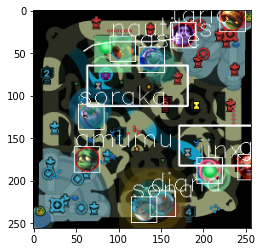

1.463062047958374
1.463062047958374


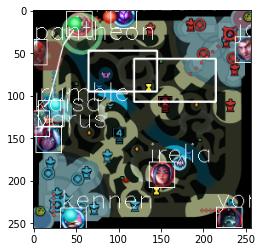

2.18456768989563
2.18456768989563


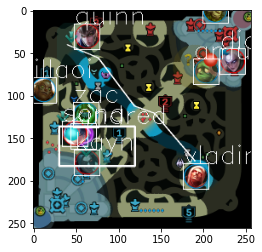

2.937525510787964
2.937525510787964


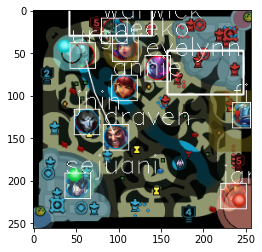

3.6439099311828613
3.6439099311828613


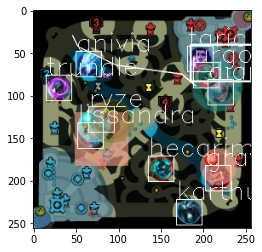

4.480208873748779
4.480208873748779


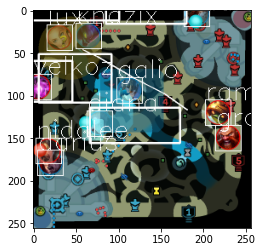

5.24047589302063
5.24047589302063
41 133 71 163
yes


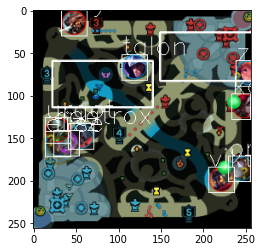

5.970621347427368
5.970621347427368


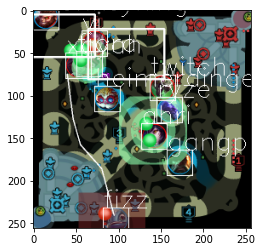

6.687844514846802
6.687844514846802
80 212 110 242
yes


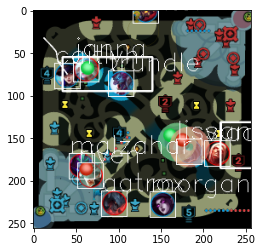

7.4334917068481445
7.4334917068481445


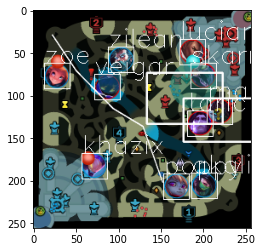

In [14]:
itr = 0
start = time.time()
for entry in data_loader:
    end = time.time()
    print(end - start)
    img, champion_data = entry
    print(end - start)
    boxes = champion_data['boxes'].numpy().tolist()
    labels = champion_data['labels'].numpy().tolist()
    img = img[0].numpy().copy()
    for label, box in zip(labels[0], boxes[0]):
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        label = dataset.id_to_champion[label]
        if label == 'aatrox':
            print(x1, y1, x2, y2)
            print('yes')
        img = img.transpose((1, 2, 0))

        img = img.copy()
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (1.0, 1.0, 1.0), 1)
        img = cv2.putText(img, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (1.0, 1.0, 1.0), thickness = 1, lineType = cv2.LINE_AA)

        img = img.transpose((2, 0, 1))
        #print(img.shape)

    img = torch.from_numpy(img)
    pil_img = transforms.ToPILImage()(img)
    plt.imshow(pil_img)
    plt.show()
    itr += 1
    if itr == 10:
        break

In [15]:
# List id -> champion name
for k, v in dataset.id_to_champion.items():
  print(k, v)

1 aatrox
2 ahri
3 akali
4 alistar
5 amumu
6 anivia
7 annie
8 aphelios
9 ashe
10 aurelionsol
11 azir
12 bard
13 blitzcrank
14 brand
15 braum
16 caitlyn
17 camille
18 cassiopeia
19 chogath
20 corki
21 darius
22 diana
23 draven
24 drmundo
25 ekko
26 elise
27 evelynn
28 ezreal
29 fiddlesticks
30 fiora
31 fizz
32 galio
33 gangplank
34 garen
35 gnar
36 gragas
37 graves
38 hecarim
39 heimerdinger
40 illaoi
41 irelia
42 ivern
43 janna
44 jarvaniv
45 jax
46 jayce
47 jhin
48 jinx
49 kaisa
50 kalista
51 karma
52 karthus
53 kassadin
54 katarina
55 kayle
56 kayn
57 kennen
58 khazix
59 kindred
60 kled
61 kogmaw
62 leblanc
63 leesin
64 leona
65 lissandra
66 lucian
67 lulu
68 lux
69 malphite
70 malzahar
71 maokai
72 masteryi
73 missfortune
74 monkeyking
75 mordekaiser
76 morgana
77 nami
78 nasus
79 nautilus
80 neeko
81 nidalee
82 nocturne
83 nunu
84 olaf
85 orianna
86 ornn
87 pantheon
88 poppy
89 pyke
90 qiyana
91 quinn
92 rakan
93 rammus
94 reksai
95 renekton
96 rengar
97 riven
98 rumble
99 ryze
100 

# Load fastercnn model

In [16]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def create_model(num_classes, device):
    # load an instance segmentation model pre-trained pre-trained on COCO
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    model.to(device)
    
    return model

num_classes = 148 + 1
num_epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch is using this device', device)
model = create_model(num_classes, device)
#print(model.backbone)
print('allocated memory', torch.cuda.memory_allocated(device))
print('reserved_memory', torch.cuda.memory_reserved(device))

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

writer = SummaryWriter('runs')

pytorch is using this device cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

allocated memory 172576256
reserved_memory 180355072


In [ ]:
# Run forever until you stop it
save_state_path = 'fastrcnn_model.pt'
save_opt_path = 'fastrcnn_opt.pt'

niter = 0
print_freq = 10
save_freq = 1000
epoch = 0
#for epoch in range(num_epochs):
while True:
    model.train()
    for imgs, annotations in data_loader:
        input_data = []
        input_images = imgs.to(device)
        
        for k, v in annotations.items():
            for i, vv in enumerate(v):
                while len(input_data) <= i:
                    input_data.append({})
                input_data[i][k] = vv.to(device)
        loss_dict = model(input_images, input_data)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        del input_images
        del input_data
        
        if niter % print_freq == 0:
            current_time = datetime.datetime.now() 
            print(f'Time {current_time}, Epoch {epoch}, Iteration: {niter}, Loss: {losses} {loss_dict}')

        if niter % save_freq == 0:
            torch.save(model.cpu().state_dict(), save_state_path)
            torch.save(optimizer.state_dict(), save_opt_path)

            !cp fastrcnn_model.pt /content/drive/My\ Drive/fastrcnn_model10.pt
            !cp fastrcnn_opt.pt /content/drive/My\ Drive/fastrcnn_opt10.pt
            !cp -r runs /content/drive/My\ Drive/runs2

            model.to(device)
            
        writer.add_scalar('Loss/train', losses, niter)
        for k, v in loss_dict.items():
            writer.add_scalar(k, v, niter)
        
        niter += 1
        
    #scheduler.step()
    epoch += 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Time 2021-09-08 00:16:14.832209, Epoch 0, Iteration: 0, Loss: 5.8128743171691895 {'loss_classifier': tensor(4.9528, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0885, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.6902, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0814, device='cuda:0', grad_fn=<DivBackward0>)}
Time 2021-09-08 00:16:57.998735, Epoch 0, Iteration: 10, Loss: 2.0176970958709717 {'loss_classifier': tensor(1.5303, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.2163, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1811, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0900, device='cuda:0', grad_fn=<DivBackward0>)}
Time 2021-09-08 00:17:32.154256, Epoch 0, Iteration: 20, Loss: 3.179544448852539 {'loss_classifier': tensor(2.0904, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': 